In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn import metrics
from sklearn import set_config 
from sklearn.utils import estimator_html_repr 
from IPython.core.display import display, HTML 
from category_encoders import TargetEncoder

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import sys

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
df = pd.read_pickle('../data/interim/train_clean_roll_up.pickle')

In [3]:
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_encoded,AppVersion_encoded,EngineVersion_encoded,OsVer_encoded,Census_OSBranch_release_encoded,IsProtected_encoded,RAM_bins
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,10.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,8.0,0,Other,13,14600,10.0,rs4_release,2.0,4-8 GB
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,3.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,3.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,1.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB


In [4]:
df.shape

(8395341, 72)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8395341 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [6]:
X = df.loc[:, df.columns != 'HasDetections']
y = df['HasDetections']

In [7]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7555806, 71)
(839535, 71)
(7555806,)
(839535,)


In [8]:
y_train.mean(), y_test.mean()

(0.498481962083198, 0.49855813039361074)

In [9]:
y_train.dtype, y_test.dtype

(Int64Dtype(), Int64Dtype())

In [10]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [11]:
id_col = ['AVProductStatesIdentifier',
                  'CountryIdentifier',
                  'CityIdentifier',
                  'OrganizationIdentifier',
                  'GeoNameIdentifier',
                  'LocaleEnglishNameIdentifier',
                  'IeVerIdentifier',
                  'Census_OEMNameIdentifier',
                  'Census_OEMModelIdentifier',
                  'Census_ProcessorManufacturerIdentifier',
                  'Census_ProcessorModelIdentifier',
                  'Census_OSInstallLanguageIdentifier',
                  'Census_OSUILocaleIdentifier',
                  'Census_FirmwareManufacturerIdentifier',
                  'Census_FirmwareVersionIdentifier',
                  'Wdft_RegionIdentifier',
                  'Census_OSBuildRevision']
cat_col = [col for col in X_train.select_dtypes('category').columns.tolist() 
           if col not in id_col]
binary_col = X_train.select_dtypes('Int64').columns.tolist()
num_col = [col for col in X_train.columns 
           if col not in cat_col
           if col not in id_col
           if col not in binary_col]

len(cat_col), len(id_col), len(binary_col), len(num_col) 

(33, 17, 14, 7)

In [12]:
len(cat_col) + len(id_col) + len(binary_col) + len(num_col)

71

In [13]:
[X_train[col].dtype for col in cat_col]

[CategoricalDtype(categories=['mse', 'win8defender', 'mseprerelease', 'windowsintune',
                   'fep', 'scep'],
 , ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 3.0, 5.0, 7.0, 8.0, 35.0], ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], ordered=False),
 CategoricalDtype(categories=['windows10', 'windows2016', 'windows7', 'windows8'], ordered=False),
 CategoricalDtype(categories=['arm64', 'x64', 'x86'], ordered=False),
 CategoricalDtype(categories=['10240', '10586', '14393', '15063', '16299', '17134', '7601',
                   '9600', 'Other'],
 , ordered=False),
 CategoricalDtype(categories=['256', '768', 'Other'], ordered=False),
 CategoricalDtype(categories=['prers5', 'rs1', 'rs2', 'rs3', 'rs4', 'th1', 'th2',
                   'windows7', 'windows8.1'],
 , ordered=False),
 CategoricalDtype(categories=['Cloud', 'Education', 'Enterprise', 'Enterprise 

In [14]:
for col in cat_col:
    X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col][X_test[col].notnull()].astype('str')
    X_test[col] = X_test[col].astype('category')

<ipython-input-14-6d7a0ba9679c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
<ipython-input-14-6d7a0ba9679c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-14-6d7a0ba9679c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [15]:
[X_train[col].dtype for col in cat_col]

[CategoricalDtype(categories=['fep', 'mse', 'mseprerelease', 'scep', 'win8defender',
                   'windowsintune'],
 , ordered=False),
 CategoricalDtype(categories=['0.0', '1.0', '3.0', '35.0', '5.0', '7.0', '8.0'], ordered=False),
 CategoricalDtype(categories=['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], ordered=False),
 CategoricalDtype(categories=['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], ordered=False),
 CategoricalDtype(categories=['windows10', 'windows2016', 'windows7', 'windows8'], ordered=False),
 CategoricalDtype(categories=['arm64', 'x64', 'x86'], ordered=False),
 CategoricalDtype(categories=['10240', '10586', '14393', '15063', '16299', '17134', '7601',
                   '9600', 'Other'],
 , ordered=False),
 CategoricalDtype(categories=['256', '768', 'Other'], ordered=False),
 CategoricalDtype(categories=['prers5', 'rs1', 'rs2', 'rs3', 'rs4', 'th1', 'th2',
                   'windows7', 'windows8.1'],
 , ordered=False),
 CategoricalDtype(categories=['Cloud

In [16]:
#for col in id_col:
#    X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
#    X_train[col] = X_train[col].astype('category')
#    X_test[col] = X_test[col][X_test[col].notnull()].astype('str')
#    X_test[col] = X_test[col].astype('category')

In [17]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
id_transformer = SimpleImputer() #TargetEncoder(smoothing=10000)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('bin', binary_transformer, binary_col),
        ('id', id_transformer, id_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [18]:
# Define model
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', 
                            eval_metric='logloss', 
                            use_label_encoder =False,
                            verbosity=0)

VarThresh = VarianceThreshold()
#selector = SelectKBest(f_classif)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('VarThresh', VarThresh),
                            #('selector', selector),
                            ('classifier', xgb_clf)
                            ])

In [19]:
set_config(display='diagram')
display(HTML(estimator_html_repr(pipeline)))

In [20]:
parameters ={'preprocessor__num__strategy': ['mean'],
              'preprocessor__bin__strategy': ['most_frequent'],
              'preprocessor__id__strategy': ['most_frequent'],
              'preprocessor__cat__imputer__strategy': ['most_frequent'],
              'classifier__learning_rate': [0.1, 0.3, 0.5],
              'classifier__gamma' : [0, 2, 5],
              'classifier__max_depth': range(1, 9, 2),
              #'classifier__colsample_bytree': [0.8, 1.0],
              'classifier__subsample': [0.5, 1],
              #'classifier__reg_alpha': [0, 0.5, 1, 10, 100],
              #'classifier__reg_lambda': [0, 0.5, 1, 1.5],
              'classifier__min_child_weight': [0.5, 1, 3],
              'classifier__n_estimators': [500, 1000, 1500]}

# Grid search
search = RandomizedSearchCV(estimator=pipeline, 
                             param_distributions=parameters,
                             n_iter = 5,
                             cv=3,
                             scoring = 'roc_auc',
                             return_train_score=True,
                             random_state=42,
                             #n_jobs = -1,
                             verbose=3)

# Preprocessing of training data, fit model 
search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.720, test=0.719) total time=91.1min
[CV 2/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.720, test=0.718) total time=36.7min
[CV 3/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                                                '...
                                        'classifier__min_child_weight': [0.5, 1,
                                                                         3],
                                        'classifier__n_estimators': [500, 1000,
                                                                     1500],
                                        'classifier__subsample': [0.5, 1],
                                        'preprocessor__bin__strategy': ['most_frequent'],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent'],
                                        'preprocessor__id__strategy': ['most_frequent'],
                                        'preprocessor__num__strategy': ['mean']},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=3)

In [21]:
# optimized model
opt_xgb_clf = search.best_estimator_
search.best_params_

{'preprocessor__num__strategy': 'mean',
 'preprocessor__id__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 1,
 'classifier__n_estimators': 1500,
 'classifier__min_child_weight': 3,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0}

In [38]:
# Predictions
y_pred_train = opt_xgb_clf.predict(X_train)
y_pred_test = opt_xgb_clf.predict(X_test)
y_pred_proba_train = opt_xgb_clf.predict_proba(X_train)
y_pred_proba_test = opt_xgb_clf.predict_proba(X_test)

In [81]:
# ROC_AUC evaluation
print('Train Set roc auc:', round(roc_auc_score(y_train, y_pred_proba_train[:, 1]), 2)) 
print('Test Set roc auc:', round(roc_auc_score(y_test, y_pred_proba_test[:, 1]), 2))

Train Set roc auc: 0.75
Test Set roc auc: 0.73


In [82]:
# classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67    420978
           1       0.67      0.66      0.66    418557

    accuracy                           0.67    839535
   macro avg       0.67      0.67      0.67    839535
weighted avg       0.67      0.67      0.67    839535



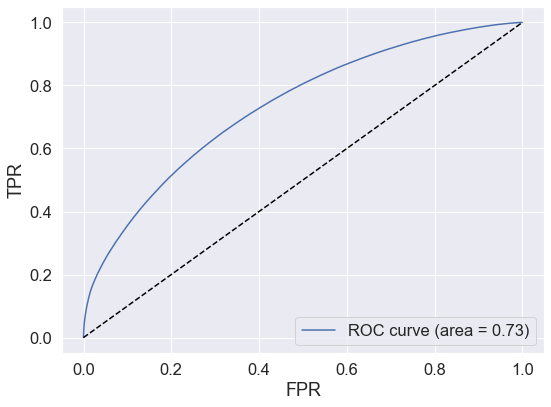

In [83]:
# plot ROC_AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_test[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = 0.73)')
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.tight_layout()

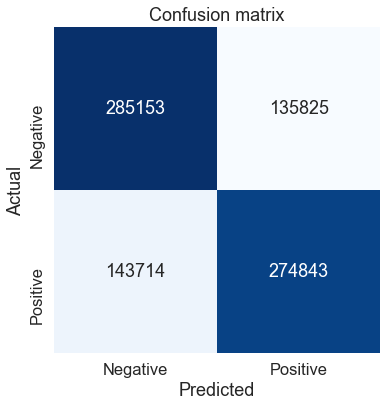

In [84]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

lables = {'Negative': 0, 'Positive': 1} 

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            annot_kws={'size':18},
            fmt='d',
            square=True,
            xticklabels=lables.keys(), 
            yticklabels=lables.keys(),
            cbar=False,
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

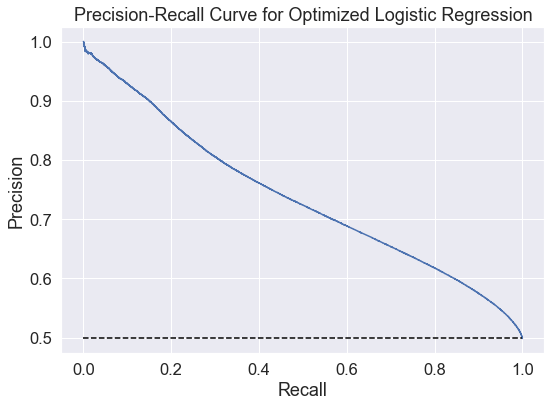

In [85]:
# plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], '--', color = 'black')
plt.title('Precision-Recall Curve for Optimized Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

In [86]:
search.best_params_

{'preprocessor__num__strategy': 'mean',
 'preprocessor__id__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 1,
 'classifier__n_estimators': 1500,
 'classifier__min_child_weight': 3,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0}

In [87]:
# Preprocessing for numerical data
numerical_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__num__strategy'])

# Preprocessing for binary data
binary_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__bin__strategy'])

# Preprocessing for categorical data encoded as numerical ID's
id_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__id__strategy'])

# Preprocessing for categorical data
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, num_col),
        ('bin', binary_transformer_rev, binary_col),
        ('id', id_transformer_rev, id_col),
        ('cat', categorical_transformer_rev, cat_col)
    ])

# Bundle preprocessing and modeling code in a pipeline
pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])

In [88]:
chosen_feat = opt_xgb_clf.named_steps['VarThresh'].get_support()
list(enumerate(chosen_feat))

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True),
 (9, True),
 (10, True),
 (11, True),
 (12, True),
 (13, True),
 (14, True),
 (15, True),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, True),
 (38, True),
 (39, True),
 (40, True),
 (41, True),
 (42, True),
 (43, True),
 (44, True),
 (45, True),
 (46, True),
 (47, True),
 (48, True),
 (49, True),
 (50, True),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, True),
 (56, True),
 (57, True),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, True),
 (63, True),
 (64, True),
 (65, True),
 (66, True),
 (67, True),
 (68, True),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, True),
 (74, True),
 (75, True),
 (76, True),
 (77, Tru

In [89]:
X_values = preprocessor_rev.fit_transform(X_train)
onehot_col = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_tot = num_col + binary_col + id_col + onehot_col.tolist()
columns_tot = [feat for bool_, feat in zip(chosen_feat, columns_tot) if bool_]

feature_importance = pd.Series(data=opt_xgb_clf.named_steps['classifier'].feature_importances_,
                               index = np.array(columns_tot))

In [90]:
feature_importance = feature_importance.sort_values(ascending=False)

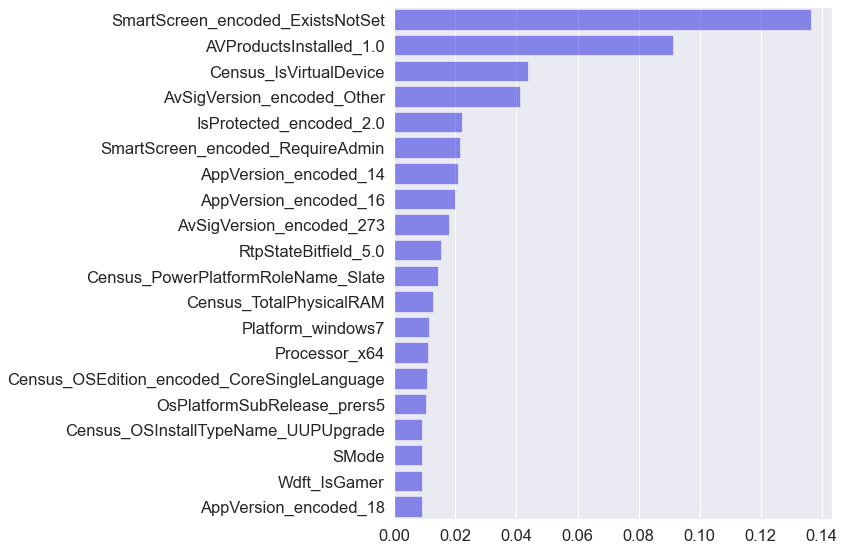

In [91]:
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20], 
            x=feature_importance.values[:20],
            color='blue',
            alpha=.5,
            orient='h')
plt.tight_layout()

# Learning curve
opt_xgb_clf_rev = opt_xgb_clf
train_sizes, train_scores, test_scores = learning_curve(opt_xgb_clf_rev, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=3, 
                                                        scoring='roc_auc',
                                                        n_jobs=1,
                                                        train_sizes=np.linspace(.01, 1.0, 4), 
                                                        verbose=3)

# Plot learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'd-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
plt.ylim(0.5, 1.01)
   
    
plt.legend(loc='best')
plt.xlabel('Training examples')
plt.ylabel('ROC_AUC Score')
plt.title('Learning Curve (XGB)')

In [92]:
# Retrain on full dataset

In [93]:
#X_train_full =
#y_train_full =

In [94]:
#opt_xgb_clf.fit(X_train_full, y_train_full)

In [95]:
with open('../models/optimized_XGB.pickle', 'wb') as handle:
    pickle.dump(opt_xgb_clf, handle)